# import 

In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# main

In [126]:
path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

In [127]:

for index, mouse_file in enumerate(os.listdir(path)):
    current_mouse_p = os.path.join(path, mouse_file)
    if 'analysis' in os.listdir(current_mouse_p):
        print(current_mouse_p)

Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\136_1_3
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\136_1_4
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\149_1_1
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\178_1_4
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\178_1_9
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\178_2_1
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\178_2_2
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\178_2_4
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\269_1_4
Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\269_1_7


In [ ]:
# set variables 
n = 0
# delta/spindle power cross correlations
spindle_z_x_corr,spindle_z_temporal_shuffle,spindle_z_phase_shuffle = [], [], []
delta_z_x_corr,delta_z_temporal_shuffle,delta_z_phase_shuffle = [],[],[]
spectral_power_time_lags = []

spindle_events_z_x_corr_replay,spindle_events_z_temporal_shuffle_replay,spindle_events_z_phase_shuffle_replay = [],[],[]


for index, mouse_file in enumerate(os.listdir(path)):
    current_mouse_p = os.path.join(path, mouse_file)
    if 'analysis' in os.listdir(current_mouse_p):
        current_mouse_path = os.path.join(current_mouse_p, r"analysis\\")
        
        # add to the n
        n= n+1
        
        # load data for cross correlations
        # delta power data 
        delta_z_x_corr += [np.load(current_mouse_path + 'delta_z_x_corr.npy', allow_pickle=True)]
        delta_z_temporal_shuffle += [np.load(current_mouse_path + 'delta_z_temporal_shuffle.npy', allow_pickle=True)]
        delta_z_phase_shuffle += [np.load(current_mouse_path + 'delta_z_phase_shuffle.npy', allow_pickle=True)]
        # spindle power data 
        aa_spindle_z_x_corr += [np.load(current_mouse_path + 'spindle_z_x_corr.npy', allow_pickle=True)]
        spindle_z_temporal_shuffle += [np.load(current_mouse_path + 'spindle_z_temporal_shuffle.npy', allow_pickle=True)]
        spindle_z_phase_shuffle += [np.load(current_mouse_path + 'spindle_z_phase_shuffle.npy', allow_pickle=True)]
        
        spectral_power_time_lags += [np.load(current_mouse_path + 'spectral_power_time_lags.npy', allow_pickle=True)]

        
        # individual spindle occurance cross correlation
        
        spindle_events_z_x_corr_replay += [np.load(current_mouse_path + 'spindle_events_z_x_corr_replay.npy')]
        spindle_events_z_temporal_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_temporal_shuffle_replay.npy')]
        spindle_events_z_phase_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_phase_shuffle_replay.npy')]
        
        if index == 4:
            break
        
        
        
        


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\oscillations\\striatum_lfp\\expert\\\\178_1_9\\analysis\\\\spindle_events_z_x_corr_replay.npy'

# power band cross correlations

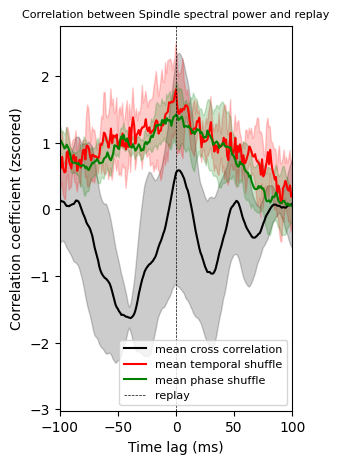

In [ ]:
## plot cross correlations DELTA POWER

mean_delta_x_corr = np.mean(delta_z_x_corr,axis=0)
std_delta_x_corr = np.std(delta_z_x_corr,axis=0)
mean_delta_temporal_shuffle = np.mean(delta_z_temporal_shuffle,axis=0)
str_delta_temporal_shuffle = np.std(delta_z_temporal_shuffle,axis=0)
mean_delta_phase_shuffle = np.mean(delta_z_phase_shuffle,axis=0)
std_delta_phase_shuffle = np.std(delta_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_delta_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_delta_x_corr - std_delta_x_corr, mean_delta_x_corr + std_delta_x_corr, alpha=0.2, color='k')

ax.plot(time_lags,mean_delta_temporal_shuffle, label='mean temporal shuffle', color='red')
ax.fill_between(time_lags, mean_delta_temporal_shuffle - str_delta_temporal_shuffle, mean_delta_temporal_shuffle + str_delta_temporal_shuffle, alpha=0.2, color='red')

ax.plot(time_lags,mean_delta_phase_shuffle, label='mean phase shuffle', color='green')
ax.fill_between(time_lags, mean_delta_phase_shuffle - std_delta_phase_shuffle, mean_delta_phase_shuffle + std_delta_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between Spindle spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.legend(loc='lower right', fontsize=8)

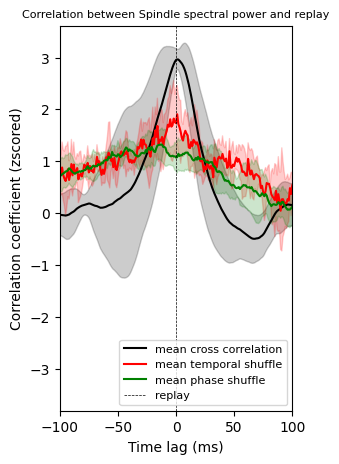

In [ ]:
## plot cross correlations SPINDLE POWER

mean_spin_x_corr = np.mean(aa_spindle_z_x_corr,axis=0)
std_spin_x_corr = np.std(aa_spindle_z_x_corr,axis=0)
mean_spin_temporal_shuffle = np.mean(spindle_z_temporal_shuffle,axis=0)
str_spindle_temporal_shuffle = np.std(spindle_z_temporal_shuffle,axis=0)
mean_spin_phase_shuffle = np.mean(spindle_z_phase_shuffle,axis=0)
std_spin_phase_shuffle = np.std(spindle_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_spin_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_x_corr - std_spin_x_corr, mean_spin_x_corr + std_spin_x_corr, alpha=0.2, color='k')

ax.plot(time_lags,mean_spin_temporal_shuffle, label='mean temporal shuffle', color='red')
ax.fill_between(time_lags, mean_spin_temporal_shuffle - str_spindle_temporal_shuffle, mean_spin_temporal_shuffle + str_spindle_temporal_shuffle, alpha=0.2, color='red')

ax.plot(time_lags,mean_spin_phase_shuffle, label='mean phase shuffle', color='green')
ax.fill_between(time_lags, mean_spin_phase_shuffle - std_spin_phase_shuffle, mean_spin_phase_shuffle + std_spin_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between Spindle spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.legend(loc='lower right', fontsize=8)

# individual spindle occurance cross correlation

In [ ]:




mean_spin_events_x_corr = np.mean(spindle_events_z_x_corr_replay,axis=0)
std_spin_events_x_corr = np.std(spindle_events_z_x_corr_replay,axis=0)
mean_spin_events_temporal_shuffle = np.mean(spindle_events_z_temporal_shuffle_replay,axis=0)
str_spindle_events_temporal_shuffle = np.std(spindle_events_z_temporal_shuffle_replay,axis=0)
mean_spin_events_phase_shuffle = np.mean(spindle_events_z_phase_shuffle_replay,axis=0)
std_spin_events_phase_shuffle = np.std(spindle_events_z_phase_shuffle_replay,axis=0)

time_lags = np.arange(-300 + 1, 300)
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(time_lags,mean_spin_events_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_events_x_corr - std_spin_events_x_corr, mean_spin_events_x_corr + std_spin_events_x_corr, alpha=0.2, color='k')

ax.plot(time_lags,mean_spin_events_temporal_shuffle, label='mean temporal shuffle', color='red')
ax.fill_between(time_lags, mean_spin_events_temporal_shuffle - str_spindle_events_temporal_shuffle, mean_spin_events_temporal_shuffle + str_spindle_events_temporal_shuffle, alpha=0.2, color='red')

ax.plot(time_lags,mean_spin_events_phase_shuffle, label='mean phase shuffle', color='green')
ax.fill_between(time_lags, mean_spin_events_phase_shuffle - std_spin_events_phase_shuffle, mean_spin_events_phase_shuffle + std_spin_events_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0,color = 'grey')
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel('Cross-correlation')
ax.set_title(f'cross correlation between spindle events and replay events, n = {n}')
ax.legend()

In [124]:
window = 1
overlap = 0.5
data_length = 600


In [123]:
time_lags

array([-149.5, -149. , -148.5, -148. , -147.5, -147. , -146.5, -146. ,
       -145.5, -145. , -144.5, -144. , -143.5, -143. , -142.5, -142. ,
       -141.5, -141. , -140.5, -140. , -139.5, -139. , -138.5, -138. ,
       -137.5, -137. , -136.5, -136. , -135.5, -135. , -134.5, -134. ,
       -133.5, -133. , -132.5, -132. , -131.5, -131. , -130.5, -130. ,
       -129.5, -129. , -128.5, -128. , -127.5, -127. , -126.5, -126. ,
       -125.5, -125. , -124.5, -124. , -123.5, -123. , -122.5, -122. ,
       -121.5, -121. , -120.5, -120. , -119.5, -119. , -118.5, -118. ,
       -117.5, -117. , -116.5, -116. , -115.5, -115. , -114.5, -114. ,
       -113.5, -113. , -112.5, -112. , -111.5, -111. , -110.5, -110. ,
       -109.5, -109. , -108.5, -108. , -107.5, -107. , -106.5, -106. ,
       -105.5, -105. , -104.5, -104. , -103.5, -103. , -102.5, -102. ,
       -101.5, -101. , -100.5, -100. ,  -99.5,  -99. ,  -98.5,  -98. ,
        -97.5,  -97. ,  -96.5,  -96. ,  -95.5,  -95. ,  -94.5,  -94. ,
      

In [102]:
np.linspace(10,1,100)

array([10.        ,  9.90909091,  9.81818182,  9.72727273,  9.63636364,
        9.54545455,  9.45454545,  9.36363636,  9.27272727,  9.18181818,
        9.09090909,  9.        ,  8.90909091,  8.81818182,  8.72727273,
        8.63636364,  8.54545455,  8.45454545,  8.36363636,  8.27272727,
        8.18181818,  8.09090909,  8.        ,  7.90909091,  7.81818182,
        7.72727273,  7.63636364,  7.54545455,  7.45454545,  7.36363636,
        7.27272727,  7.18181818,  7.09090909,  7.        ,  6.90909091,
        6.81818182,  6.72727273,  6.63636364,  6.54545455,  6.45454545,
        6.36363636,  6.27272727,  6.18181818,  6.09090909,  6.        ,
        5.90909091,  5.81818182,  5.72727273,  5.63636364,  5.54545455,
        5.45454545,  5.36363636,  5.27272727,  5.18181818,  5.09090909,
        5.        ,  4.90909091,  4.81818182,  4.72727273,  4.63636364,
        4.54545455,  4.45454545,  4.36363636,  4.27272727,  4.18181818,
        4.09090909,  4.        ,  3.90909091,  3.81818182,  3.72

# Linkage analysis - Time Lag from replay to closest spindle

# PSTHs for spindles and replay

# spindle amplitude + magnitude vs proximity to replay 
also plot average feature size near replay vs far from replay

# average event triggered average

#

In [ ]:
#plot cross correlation average across mice


In [ ]:
spindle_z_x_corr

array([-9.22753886e-01, -9.85426433e-01, -1.04851484e+00, -1.10616168e+00,
       -1.16181183e+00, -1.20768744e+00, -1.24310011e+00, -1.26912946e+00,
       -1.29862751e+00, -1.32267908e+00, -1.33093902e+00, -1.32554304e+00,
       -1.30811170e+00, -1.27467972e+00, -1.24119186e+00, -1.19874186e+00,
       -1.14326794e+00, -1.07501007e+00, -1.00286507e+00, -9.26731014e-01,
       -8.49731931e-01, -7.72120994e-01, -6.87548511e-01, -6.07507715e-01,
       -5.29200881e-01, -4.44868049e-01, -3.65008107e-01, -2.76898515e-01,
       -1.85972750e-01, -9.66873579e-02, -1.65353170e-02,  5.67612776e-02,
        1.19969680e-01,  1.76750740e-01,  2.36114843e-01,  2.93746284e-01,
        3.45191084e-01,  3.93896955e-01,  4.51406525e-01,  5.04748430e-01,
        5.73166449e-01,  6.39624451e-01,  7.09726248e-01,  7.74916092e-01,
        8.39809112e-01,  8.88502686e-01,  9.32994343e-01,  9.68958637e-01,
        1.00785621e+00,  1.04175451e+00,  1.07892810e+00,  1.11930282e+00,
        1.15759334e+00,  

In [ ]:
    #save out the data
    np.save(output_path + 'delta_z_x_corr.npy',delta_z_x_corr)
    np.save(output_path + 'delta_z_temporal_shuffle.npy',delta_z_temporal_shuffle)
    np.save(output_path + 'delta_z_phase_shuffle.npy',delta_z_phase_shuffle)
    np.save(output_path + 'spindle_z_x_corr.npy',spindle_z_x_corr)
    np.save(output_path + 'spindle_z_temporal_shuffle.npy',spindle_z_temporal_shuffle)
    np.save(output_path + 'spindle_z_phase_shuffle.npy',spindle_z_phase_shuffle)

In [22]:
os.listdir(current_mouse_path)

['average_signal.npy',
 'average_signal_rect.npy',
 'chunk_spind_av_magnitudes.npy',
 'chunk_spind_lengths.npy',
 'chunk_spind_peaks.npy',
 'chunk_spind_total_magnitude.npy',
 'cross_correlation_delta_spindle_replay.png',
 'delta_spectral_power_vs_replay.png',
 'delta_z_phase_shuffle.npy',
 'delta_z_temporal_shuffle.npy',
 'delta_z_x_corr.npy',
 'distance_to_replay.npy',
 'event_by_event_psth_replay_bins.npy',
 'event_by_event_psth_spindle_bins.npy',
 'event_by_event_zscored_psth_replay.npy',
 'event_by_event_zscored_psth_spindles.npy',
 'peak_algined_average_signal.npy',
 'peak_sems.npy',
 'PSTH_event_by_event.png',
 'random_average_signal.npy',
 'random_average_signal_rect.npy',
 'random_peak_algined_average_signal.npy',
 'random_peak_sems.npy',
 'spindle_features_vs_distance_to_replay.png',
 'spindle_identification.png',
 'spindle_linkage_distance.npy',
 'spindle_linkage_distance.png',
 'spindle_linkage_distance_random_replay.npy',
 'spindle_linkage_distance_random_spindles.npy',
 '

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\oscillations\\striatum_lfp\\expert\\\\seq008_1_3\\analysis'